In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # charts plotting
import plotly.graph_objects as go # more customized plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option("display.max_columns", None)

In [2]:
df_retail = pd.read_csv('/content/drive/MyDrive/Spinmaster/OnlineRetail.csv')

# Initial Data Cleaning
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])
df_retail = df_retail[df_retail['CustomerID'].notna()]
df_retail['CustomerID'] = df_retail['CustomerID'].astype(int)
df_retail = df_retail.sort_values('InvoiceDate')
df_retail['Total'] = df_retail['Quantity'] * df_retail['UnitPrice']

# Target Data - UK and Top 20 Items in total revenue
df_uk = df_retail.loc[df_retail["Country"]== "United Kingdom"]
df_target = df_uk.groupby(["StockCode","Description"])["Total"].agg({"sum"}).sort_values('sum',ascending=False).head(20)
df_target.rename(columns={'sum': 'Revenue'}, inplace=True)
df_target.reset_index(level=['StockCode', 'Description'],inplace=True)

# Target Data filtering
df_target_data = df_uk[df_uk['StockCode'].isin(df_target['StockCode'])]
print(df_target_data.shape)
print(df_target_data["StockCode"].value_counts())
df_target_data.head()

(18648, 9)
StockCode
85123A    1987
22423     1574
85099B    1505
84879     1343
47566     1327
22720     1080
22086      991
22469      963
23298      939
22386      844
22960      829
22470      825
22178      818
22910      704
85099F     645
23284      630
82484      585
79321      519
21137      304
22502      236
Name: count, dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748,United Kingdom,204.00
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,15.30


In [3]:
# Missing Data Analysis
missing_data = df_target_data.isnull().sum()
print("Missing Values Analysis:")
print(missing_data)

Missing Values Analysis:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Total          0
dtype: int64


In [4]:
# Remove cancelled orders (invoices starting with 'C')
df_target_data1 = df_target_data[~df_target_data['InvoiceNo'].str.contains('C', na=False)]
print(df_target_data1.shape)

(18118, 9)


In [5]:
def plot_boxplots(df, stock_code):
  """
  Creates boxplots for unit price and quantity for a given StockCode.

  Args:
    df: The DataFrame containing the data.
    stock_code: The StockCode for which to create the boxplots.
  """

  # Filter data for the specified StockCode
  stock_data = df[df['StockCode'] == stock_code]

  # Create subplots
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # Plot boxplot for UnitPrice
  sns.boxplot(ax=axes[0], y='UnitPrice', data=stock_data)
  axes[0].set_title(f'Boxplot of UnitPrice for StockCode {stock_code}')

  # Plot boxplot for Quantity
  sns.boxplot(ax=axes[1], y='Quantity', data=stock_data)
  axes[1].set_title(f'Boxplot of Quantity for StockCode {stock_code}')

  plt.tight_layout()
  plt.show()
# Example usage (replace '85123A' with your desired StockCode)


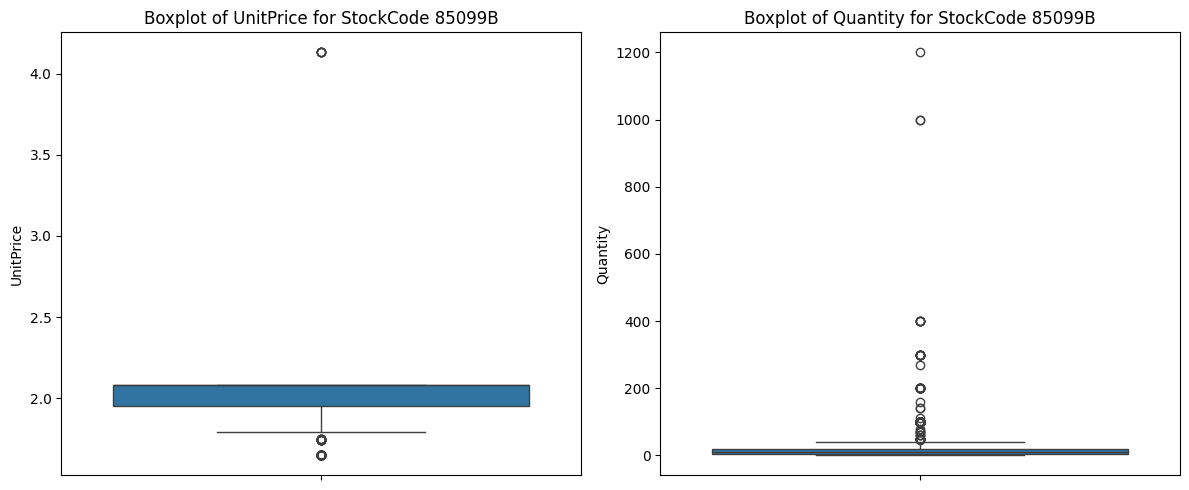

In [6]:
plot_boxplots(df_target_data1, '85099B')

In [7]:
# prompt: remove outliers for each stockcode

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

def remove_outliers_by_stockcode(df):
    df_no_outliers = pd.DataFrame()
    for stock_code in df['StockCode'].unique():
        stock_df = df[df['StockCode'] == stock_code]
        stock_df_no_outliers_price = remove_outliers_iqr(stock_df, 'UnitPrice')
        stock_df_no_outliers = remove_outliers_iqr(stock_df_no_outliers_price, 'Quantity')
        df_no_outliers = pd.concat([df_no_outliers, stock_df_no_outliers], ignore_index=True)
    return df_no_outliers

df_target_data2 = remove_outliers_by_stockcode(df_target_data1)
df_target_data2.shape


(15155, 9)

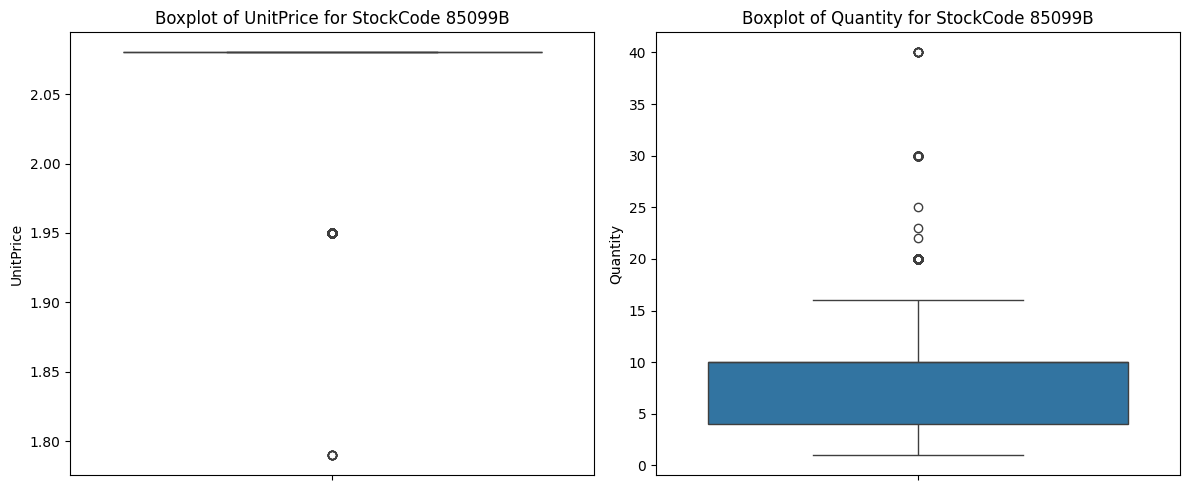

In [ ]:
plot_boxplots(df_target_data2, '85099B')

In [8]:
df_target_data2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536401,85123A,WHITE HANGING HEART T-LIGHT HOLDER,4,2010-12-01 11:21:00,2.95,15862,United Kingdom,11.80
1,536502,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 12:36:00,2.95,16552,United Kingdom,17.70
2,536520,85123A,WHITE HANGING HEART T-LIGHT HOLDER,3,2010-12-01 12:43:00,2.95,14729,United Kingdom,8.85
3,536590,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 16:52:00,2.95,13065,United Kingdom,17.70
4,536594,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 17:22:00,2.95,15235,United Kingdom,17.70


In [11]:
# Extract Time based features

# Weekend Flag
df_target_data3 = df_target_data2.copy()
df_target_data3['InvoiceDayOfWeek'] = df_target_data2['InvoiceDate'].dt.dayofweek
# Monday=0, Sunday=6
df_target_data3['IsWeekend'] = df_target_data3['InvoiceDayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Week of Year
df_target_data3['WeekOfYear'] = df_target_data2['InvoiceDate'].dt.isocalendar().week

# Month
df_target_data3['Month'] = df_target_data2['InvoiceDate'].dt.month

df_target_data3.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,InvoiceDayOfWeek,IsWeekend,WeekOfYear,Month
3383,564065,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2011-08-22 15:05:00,2.95,15150,United Kingdom,17.70,0,0,34,8
9424,541593,22178,VICTORIAN GLASS HANGING T-LIGHT,6,2011-01-19 15:20:00,1.25,17611,United Kingdom,7.50,2,0,3,1
14670,559317,23298,SPOTTY BUNTING,3,2011-07-07 14:03:00,4.95,17611,United Kingdom,14.85,3,0,27,7
13624,566248,22720,SET OF 3 CAKE TINS PANTRY DESIGN,3,2011-09-11 12:06:00,4.95,13272,United Kingdom,14.85,6,1,36,9
14910,566290,23298,SPOTTY BUNTING,1,2011-09-11 15:24:00,4.95,14456,United Kingdom,4.95,6,1,36,9


In [12]:
# Create product-based features
df_target_data4 = df_target_data3.copy()
df_target_data4['ProductAvgPrice'] = df_target_data4.groupby('StockCode')['UnitPrice'].transform('mean')
df_target_data4['ProductSaleFrequency'] = df_target_data4.groupby('StockCode')['Quantity'].transform('count')

# Create customer-based features
df_target_data4['CustomerOrderCount'] = df_target_data4.groupby('CustomerID')['InvoiceNo'].transform('count')
df_target_data4.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,InvoiceDayOfWeek,IsWeekend,WeekOfYear,Month,ProductAvgPrice,ProductSaleFrequency,CustomerOrderCount
14535,555562,23298,SPOTTY BUNTING,6,2011-06-05 14:45:00,4.95,17841,United Kingdom,29.70,6,1,22,6,4.950000,807,268
618,551713,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2011-05-03 15:12:00,2.95,16230,United Kingdom,17.70,1,0,18,5,2.950000,1517,3
7963,574624,85099B,JUMBO BAG RED RETROSPOT,5,2011-11-06 11:20:00,2.08,17769,United Kingdom,10.40,6,1,44,11,2.049311,1248,24
5324,536945,22469,HEART OF WICKER SMALL,1,2010-12-03 12:24:00,1.65,14083,United Kingdom,1.65,4,0,48,12,1.650000,852,4
5010,554379,82484,WOOD BLACK BOARD ANT WHITE FINISH,12,2011-05-24 11:35:00,6.75,14047,United Kingdom,81.00,1,0,21,5,7.542579,539,1


In [ ]:
df_target_data5 = df_target_data4.copy()

# One hot encoding of Invoice Month
df_target_data5 = pd.get_dummies(df_target_data5, columns=['Month'], prefix='Month',drop_first=True)

month_cols = [col for col in df_target_data5.columns if col.startswith('Month_')]
df_target_data5[month_cols] = df_target_data5[month_cols].astype(int)

# Target Encoding for Each Stockcode
# Calculate the mean of 'Quantity' for each 'StockCode'
stockcode_target_encoding = df_target_data5.groupby('StockCode')['Quantity'].mean()

# Merge the target encoding back into the main DataFrame
df_target_data5['StockCode_TargetEncoded'] = df_target_data5['StockCode'].map(stockcode_target_encoding)

df_target_data5.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,InvoiceDayOfWeek,IsWeekend,WeekOfYear,ProductAvgPrice,ProductSaleFrequency,CustomerOrderCount,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,StockCode_TargetEncoded
213,541676,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12,2011-01-20 14:01:00,2.95,15379,United Kingdom,35.40,3,0,3,2.950000,1517,15,0,0,0,0,0,0,0,0,0,0,0,5.630850
5906,568387,22469,HEART OF WICKER SMALL,12,2011-09-27 10:04:00,1.65,13704,United Kingdom,19.80,1,0,39,1.650000,852,7,0,0,0,0,0,0,0,1,0,0,0,8.030516
1084,565778,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12,2011-09-06 15:04:00,2.95,17460,United Kingdom,35.40,1,0,36,2.950000,1517,4,0,0,0,0,0,0,0,1,0,0,0,5.630850
14279,576362,23284,DOORMAT KEEP CALM AND COME IN,2,2011-11-14 17:11:00,8.25,14755,United Kingdom,16.50,0,0,46,8.093736,455,33,0,0,0,0,0,0,0,0,0,1,0,2.373626
13384,547918,22720,SET OF 3 CAKE TINS PANTRY DESIGN,3,2011-03-28 12:49:00,4.95,15249,United Kingdom,14.85,0,0,13,4.950000,823,22,0,1,0,0,0,0,0,0,0,0,0,2.465371


In [ ]:
feat_sel = [ 'UnitPrice', 'IsWeekend', 'ProductAvgPrice', 'ProductSaleFrequency',
  'CustomerOrderCount', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
  'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
  'Month_12', 'StockCode_TargetEncoded', 'Quantity']
df_target_data6 = df_target_data5[feat_sel]
df_target_data6.head()

,UnitPrice,IsWeekend,ProductAvgPrice,ProductSaleFrequency,CustomerOrderCount,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,StockCode_TargetEncoded,Quantity
0,2.95,0,2.95,1517,6,0,0,0,0,0,0,0,0,0,0,1,5.63085,4
1,2.95,0,2.95,1517,3,0,0,0,0,0,0,0,0,0,0,1,5.63085,6
2,2.95,0,2.95,1517,4,0,0,0,0,0,0,0,0,0,0,1,5.63085,3
3,2.95,0,2.95,1517,1,0,0,0,0,0,0,0,0,0,0,1,5.63085,6
4,2.95,0,2.95,1517,6,0,0,0,0,0,0,0,0,0,0,1,5.63085,6


In [ ]:
df_target_data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15155 entries, 0 to 15154
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UnitPrice                15155 non-null  float64
 1   IsWeekend                15155 non-null  int64  
 2   ProductAvgPrice          15155 non-null  float64
 3   ProductSaleFrequency     15155 non-null  int64  
 4   CustomerOrderCount       15155 non-null  int64  
 5   Month_2                  15155 non-null  int64  
 6   Month_3                  15155 non-null  int64  
 7   Month_4                  15155 non-null  int64  
 8   Month_5                  15155 non-null  int64  
 9   Month_6                  15155 non-null  int64  
 10  Month_7                  15155 non-null  int64  
 11  Month_8                  15155 non-null  int64  
 12  Month_9                  15155 non-null  int64  
 13  Month_10                 15155 non-null  int64  
 14  Month_11              

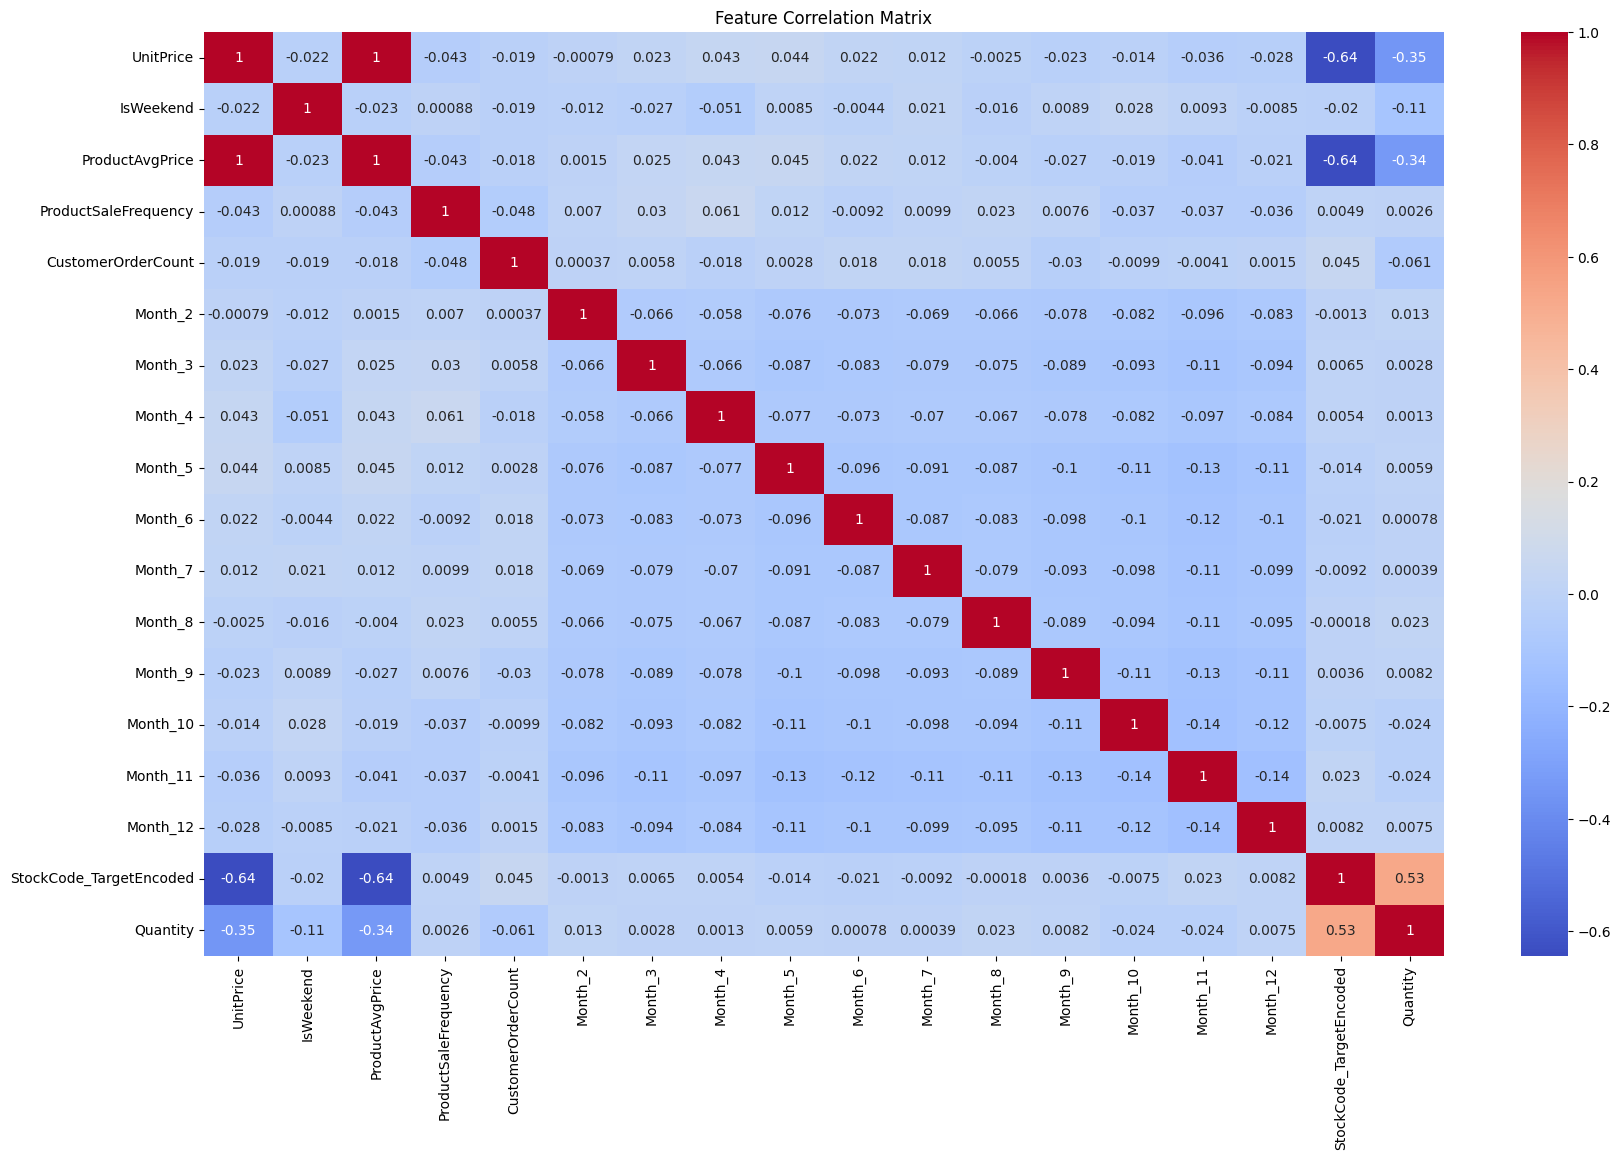

In [ ]:
# Define features for analysis
features = feat_sel[:-1]

# Create correlation matrix visualization
plt.figure(figsize=(20, 12))
correlation_matrix = df_target_data6[features + ['Quantity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
features.remove('ProductAvgPrice')

In [ ]:
features

['UnitPrice',
 'IsWeekend',
 'ProductSaleFrequency',
 'CustomerOrderCount',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'StockCode_TargetEncoded']

In [ ]:
X = df_target_data6[features]
y = df_target_data6['Quantity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

In [ ]:
print('Model Performance Metrics:')
print(f'R² Score: {r2_score(y_test, y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Model Performance Metrics:
R² Score: 0.326
RMSE: 5.272
MAE: 3.455

Feature Importance:
                    Feature  Coefficient
15  StockCode_TargetEncoded     3.255610
10                  Month_8     0.202482
7                   Month_5     0.162081
4                   Month_2     0.147958
8                   Month_6     0.133508
9                   Month_7     0.125466
11                  Month_9     0.107997
5                   Month_3     0.067414
14                 Month_12     0.062481
6                   Month_4     0.054267
12                 Month_10    -0.031970
2      ProductSaleFrequency    -0.058631
13                 Month_11    -0.090019
0                 UnitPrice    -0.173637
3        CustomerOrderCount    -0.532538
1                 IsWeekend    -0.626072


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)  # You can adjust hyperparameters here
tree_model.fit(X_train_scaled, y_train)

# Make predictions
tree_y_pred = tree_model.predict(X_test_scaled)

# Evaluate the model
print('Decision Tree Model Performance Metrics:')
print(f'R² Score: {r2_score(y_test, tree_y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, tree_y_pred)):.3f}')
print(f'MAE: {mean_absolute_error(y_test, tree_y_pred):.3f}')

# Feature importance for the Decision Tree model
feature_importance_tree = pd.DataFrame({
    'Feature': features,
    'Importance': tree_model.feature_importances_
})
print("\nDecision Tree Feature Importance:")
print(feature_importance_tree.sort_values(by='Importance', ascending=False))

Decision Tree Model Performance Metrics:
R² Score: 0.173
RMSE: 5.841
MAE: 3.547

Decision Tree Feature Importance:
                    Feature  Importance
15  StockCode_TargetEncoded    0.338307
3        CustomerOrderCount    0.249344
0                 UnitPrice    0.142876
2      ProductSaleFrequency    0.079247
14                 Month_12    0.020152
13                 Month_11    0.019901
1                 IsWeekend    0.018651
8                   Month_6    0.017658
10                  Month_8    0.017226
7                   Month_5    0.016152
5                   Month_3    0.015847
11                  Month_9    0.015403
9                   Month_7    0.015124
12                 Month_10    0.014788
4                   Month_2    0.013231
6                   Month_4    0.006093


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100) # You can adjust hyperparameters here
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
print('Random Forest Model Performance Metrics:')
print(f'R² Score: {r2_score(y_test, rf_y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, rf_y_pred)):.3f}')
print(f'MAE: {mean_absolute_error(y_test, rf_y_pred):.3f}')

# Feature importance for the Random Forest model
feature_importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
print("\nRandom Forest Feature Importance:")
print(feature_importance_rf.sort_values(by='Importance', ascending=False))

Random Forest Model Performance Metrics:
R² Score: 0.376
RMSE: 5.074
MAE: 3.255

Random Forest Feature Importance:
                    Feature  Importance
15  StockCode_TargetEncoded    0.331677
3        CustomerOrderCount    0.269655
0                 UnitPrice    0.153612
2      ProductSaleFrequency    0.048794
14                 Month_12    0.025347
1                 IsWeekend    0.021222
13                 Month_11    0.018299
10                  Month_8    0.018199
5                   Month_3    0.016766
7                   Month_5    0.015677
12                 Month_10    0.015526
11                  Month_9    0.015384
8                   Month_6    0.014351
9                   Month_7    0.013937
4                   Month_2    0.013334
6                   Month_4    0.008221


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

# Initialize and train the AdaBoost Regressor
ada_model = AdaBoostRegressor(random_state=42, n_estimators=100) # You can adjust hyperparameters here
ada_model.fit(X_train_scaled, y_train)

# Make predictions
ada_y_pred = ada_model.predict(X_test_scaled)

# Evaluate the model
print('AdaBoost Model Performance Metrics:')
print(f'R² Score: {r2_score(y_test, ada_y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, ada_y_pred)):.3f}')
print(f'MAE: {mean_absolute_error(y_test, ada_y_pred):.3f}')

# Feature importance for the AdaBoost model
feature_importance_ada = pd.DataFrame({
    'Feature': features,
    'Importance': ada_model.feature_importances_
})
print("\nAdaBoost Feature Importance:")
print(feature_importance_ada.sort_values(by='Importance', ascending=False))

AdaBoost Model Performance Metrics:
R² Score: 0.264
RMSE: 5.509
MAE: 3.762

AdaBoost Feature Importance:
                    Feature  Importance
15  StockCode_TargetEncoded    0.730694
0                 UnitPrice    0.156563
2      ProductSaleFrequency    0.094107
1                 IsWeekend    0.009778
3        CustomerOrderCount    0.008046
5                   Month_3    0.000421
8                   Month_6    0.000318
14                 Month_12    0.000072
7                   Month_5    0.000000
6                   Month_4    0.000000
4                   Month_2    0.000000
9                   Month_7    0.000000
11                  Month_9    0.000000
10                  Month_8    0.000000
13                 Month_11    0.000000
12                 Month_10    0.000000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 46.6393 - mae: 4.3369 - val_loss: 29.7421 - val_mae: 3.4987
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31.5052 - mae: 3.5538 - val_loss: 29.3489 - val_mae: 3.3469
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 31.0432 - mae: 3.5297 - val_loss: 28.9229 - val_mae: 3.4144
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27.8175 - mae: 3.3950 - val_loss: 28.7068 - val_mae: 3.3713
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 28.5488 - mae: 3.4518 - val_loss: 28.5095 - val_mae: 3.3907
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.8681 - mae: 3.5281 - val_loss: 28.5186 - val_mae: 3.4319
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 28.5771 - mae: 3.4296 - val_loss: 28.4649 - val_mae: 3.4083
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.1615 - mae: 3.4645 - val_loss: 28.8562 - val_mae: 3.3307
Epoch 9/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 

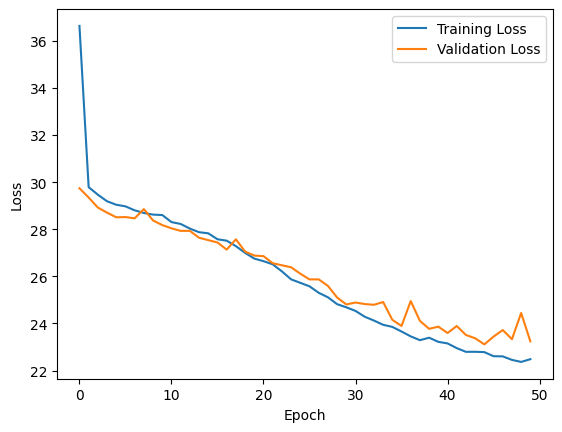

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are defined as in your provided code

# Define the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Mean Absolute Error: {mae}")

# Make predictions
y_pred = model.predict(X_test_scaled)

# Further analysis, visualization of training history, etc. can be added here
# For example, plotting the training and validation loss over epochs:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(f'R² Score: {r2_score(y_test, y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')

R² Score: 0.393
RMSE: 5.002
MAE: 3.292
